Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
# FOLDER = "images"

# OLD_TRAIN_DIR = f"{FOLDER}/Жуковский образцы почерка"
# TRAIN_DIR = f"{FOLDER}/train"

# OLD_TEST_DIR = f"{FOLDER}/Конволюты"
# TEST_DIR = f"{FOLDER}/test"

# NEW_TRAIN_DIR = f"{FOLDER}/new_train"
# NEW_TEST_DIR = f"{FOLDER}/new_test"
# IMG_SIZE = (3024, 4032)

DATA = "data"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

BATCH_SIZE = 8
PATH = "m.pth"
import torch
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms

from src.functions import *
from src.dataset import *
from src.train import *


print(f"{DEVICE = }")

DEVICE = device(type='cuda')


In [4]:
# seed_everything(42)
"seed_everything(42)"

'seed_everything(42)'

# torchvision.transforms

In [5]:
# data_transform = transforms.Compose([
#     # transforms.Resize(size=(224, 224)),
#     transforms.RandomCrop(300),
#     # Flip the images randomly on the horizontal
#     # transforms.RandomHorizontalFlip(p=1), # p = probability of flip, 0.5 = 50% chance
#     # Turn the image into a torch.Tensor
#     transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
# ])


# tranf = transforms.Compose([
#         # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
#         # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
#         transforms.RandomCrop(224)
#         # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#         transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
#     ])

In [6]:
# files_names = sorted(os.listdir(IMG_POS))
# image_paths  = [os.path.join(IMG_POS, i) for i in files_names]

# plot_transformed_images(image_paths, transform=data_transform)

# Dataset

In [7]:
data_transform = transforms.Compose([
    transforms.RandomCrop(300),
    transforms.ToTensor()
])

pos_dataset = Positive_Dataset(DATA_POS, augmentation=11, transform=data_transform)
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = Negative_Dataset(DATA_NEG, augmentation=1, transform=data_transform)
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

Positive: 242    (22)
Negative: 224    (224)
ConcatDataset: 466


In [8]:
neg_dataset[0][0][:, :5, :5]

tensor([[[0.6471, 0.6314, 0.6353, 0.6510, 0.6784],
         [0.6627, 0.6588, 0.6510, 0.6510, 0.6118],
         [0.6431, 0.6667, 0.6745, 0.6745, 0.6000],
         [0.6392, 0.6588, 0.6667, 0.6667, 0.6667],
         [0.6627, 0.6549, 0.6431, 0.6353, 0.6980]],

        [[0.6118, 0.5961, 0.6000, 0.6157, 0.6510],
         [0.6235, 0.6235, 0.6118, 0.6157, 0.5843],
         [0.6039, 0.6275, 0.6353, 0.6353, 0.5725],
         [0.6000, 0.6196, 0.6275, 0.6275, 0.6431],
         [0.6235, 0.6157, 0.6039, 0.5961, 0.6745]],

        [[0.4980, 0.4745, 0.4863, 0.5020, 0.5412],
         [0.5176, 0.5098, 0.5059, 0.5020, 0.4745],
         [0.4980, 0.5216, 0.5294, 0.5294, 0.4588],
         [0.5020, 0.5216, 0.5294, 0.5216, 0.5176],
         [0.5255, 0.5098, 0.5059, 0.4902, 0.5490]]])

In [9]:
# seed_everything(42)

# n = []

# l = len(pos_dataset.files_names)
# for i, (img, cl) in enumerate(pos_dataset):
#     fname = pos_dataset.files_names[i % l]
#     file, ext = os.path.splitext(fname)
#     # print(fname)
#     n.append(f"{file}_{i // l}{ext}")
#     # print(f"{file}#{i // l}{ext}\n")
#     # img.save(os.path.join(DATA_POS, f"{file}#{i // l}{ext}"))

In [10]:
# в тренировочную выборку отнесем 80% всех картинок

train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

seed_everything(42)
train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}\n Test: {len(test_dataset)}")

Train: 372
 Test: 94


In [11]:
train_dataset[0][0][:, :5, :5]

tensor([[[0.6588, 0.6510, 0.6471, 0.6431, 0.6471],
         [0.6706, 0.6235, 0.6118, 0.6039, 0.6118],
         [0.6667, 0.6392, 0.6353, 0.6392, 0.6510],
         [0.6510, 0.6196, 0.6392, 0.6627, 0.6706],
         [0.6392, 0.5882, 0.6118, 0.6392, 0.6471]],

        [[0.6784, 0.6706, 0.6667, 0.6627, 0.6667],
         [0.6902, 0.6431, 0.6314, 0.6235, 0.6314],
         [0.6863, 0.6588, 0.6549, 0.6588, 0.6706],
         [0.6706, 0.6392, 0.6588, 0.6824, 0.6902],
         [0.6588, 0.6078, 0.6314, 0.6588, 0.6667]],

        [[0.6510, 0.6431, 0.6392, 0.6353, 0.6392],
         [0.6627, 0.6157, 0.6039, 0.5961, 0.6039],
         [0.6588, 0.6314, 0.6275, 0.6314, 0.6431],
         [0.6431, 0.6118, 0.6314, 0.6549, 0.6627],
         [0.6314, 0.5804, 0.6039, 0.6314, 0.6392]]])

# Dataloader

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 47
 Test batches: 12


In [39]:
pos_neg(train_loader)

{'1': 200, '0': 172, 'total': 372}

In [40]:
pos_neg(test_loader)

{'1': 42, '0': 52, 'total': 94}

torch.Size([8, 3, 300, 300]) tensor([0, 1, 1, 0, 0, 0, 0, 1])


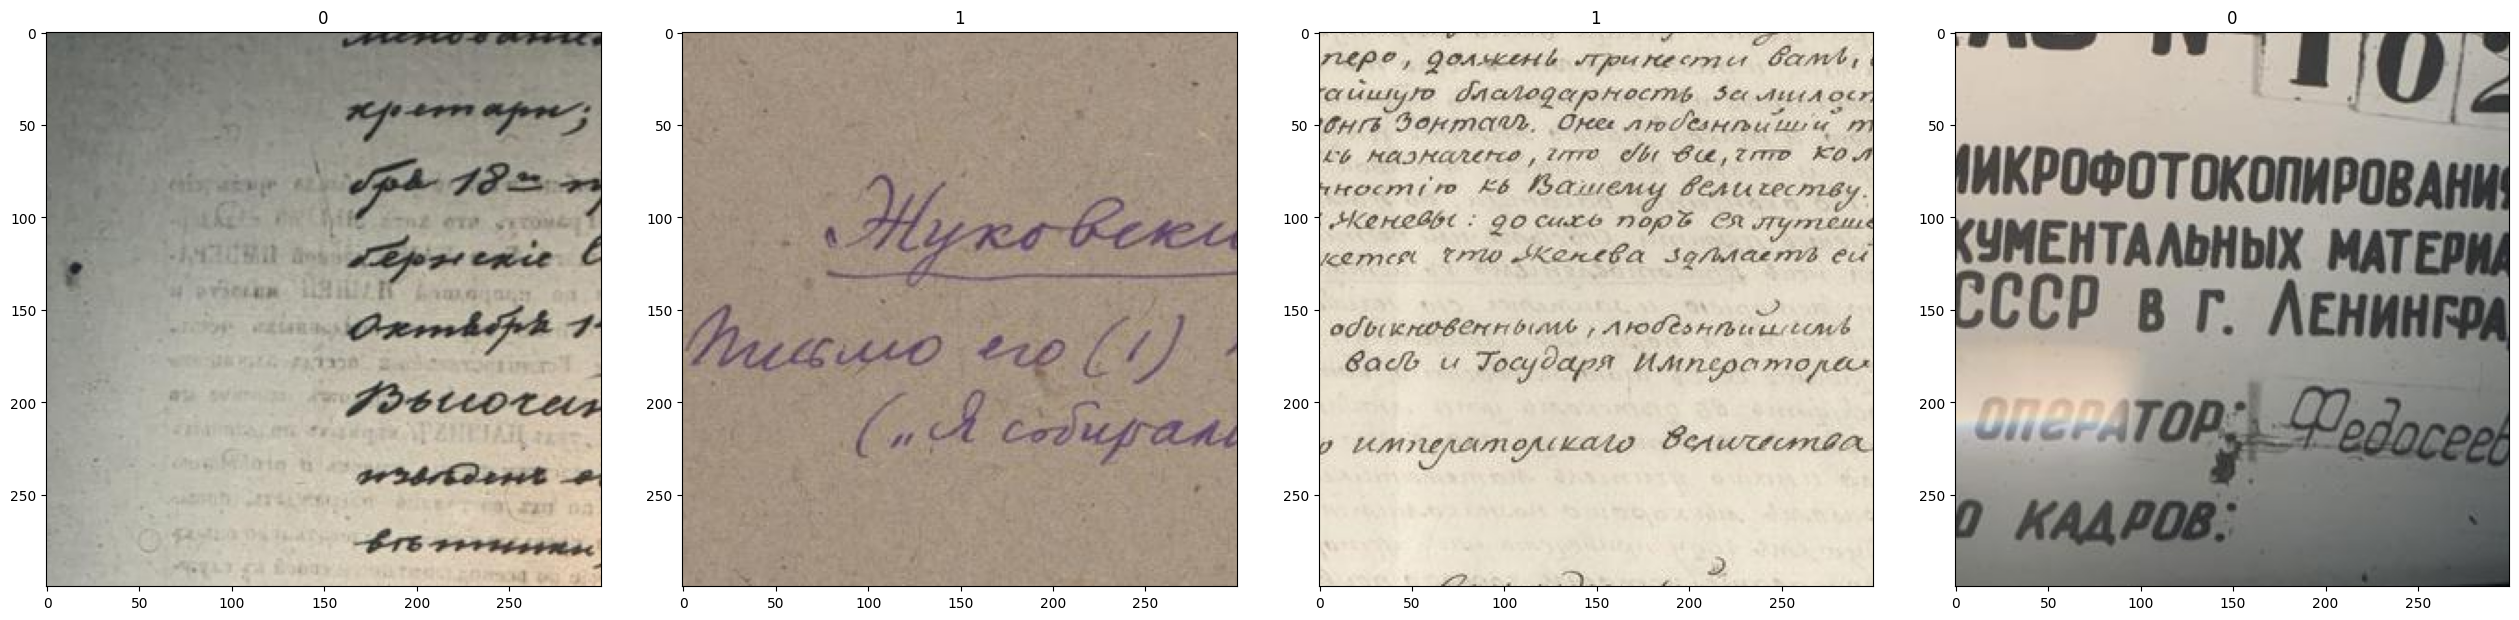

In [41]:
images, labels = next(iter(test_loader))
print(images.shape, labels)
show_images(images, labels)

# freeze_layers

In [54]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())
# dir(model)

In [55]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [56]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

seed_everything(42)
model = create_model(model, num_layers - 1, num_classes).to(DEVICE)

Число слоёв: 10
Число классов: 2


In [57]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [58]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

# train

In [59]:
%time

seed_everything(42)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=5)
torch.save(model.state_dict(), PATH)

# CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
# Wall time: 7.63 µs
# Epoch: 1
# Эпоха 1/5: val лосс и accuracy: 0.7627453903357188 0.30851063
# Epoch: 2
# Эпоха 2/5: val лосс и accuracy: 0.6513818105061849 0.5319149
# Epoch: 3
# Эпоха 3/5: val лосс и accuracy: 0.5922031948963801 0.7553192
# Epoch: 4
# Эпоха 4/5: val лосс и accuracy: 0.5416796331604322 0.84042555
# Epoch: 5
# Эпоха 5/5: val лосс и accuracy: 0.4981542726357778 0.87234044

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Epoch: 1
Эпоха 1/5: val лосс и accuracy: 0.7627453903357188 0.30851063
Epoch: 2
Эпоха 2/5: val лосс и accuracy: 0.6513818105061849 0.5319149
Epoch: 3
Эпоха 3/5: val лосс и accuracy: 0.5922031948963801 0.7553192
Epoch: 4
Эпоха 4/5: val лосс и accuracy: 0.5416796331604322 0.84042555
Epoch: 5
Эпоха 5/5: val лосс и accuracy: 0.4981542726357778 0.87234044


# Код визуализации

In [22]:
def show_images(images, labels, n = 4):
    # f, axes= plt.subplots(n//4, 4, figsize=(30,10))


    num_pic = min(len(images), n)
    width, height = 4, num_pic // 4 + 1

    # plt.figure(figsize=(6.4 * width, 6))

    for i in range(num_pic):

        if i % width == 0:
            plt.figure(figsize=(6.4 * width, 6))

        # plt.subplot(height, width, i + 1)
        plt.subplot(1, width, i % width + 1)

        img = images[i]
        img = np.transpose(img, (1, 2, 0))

        plt.imshow(img)
        if torch.is_tensor(labels[i]):
            plt.title(labels[i].numpy())
        else:
            plt.title(labels[i])

        if i % width == width - 1:
            plt.tight_layout()
            plt.show()

    plt.show()

In [23]:
def show_result(model, dataset, threshold, greater = True, col = 8, seed = 42, sort = False):
    seed_everything(seed)

    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

    y_pred, y_true, y_prob, X = get_predictions(model, loader)

    if sort:
        s, indices = torch.sort(y_prob)
        y_pred = y_pred[indices]
        y_prob = y_prob[indices]
        X = X[indices]

    if greater:
        idx = np.where(y_prob > threshold)[0]
    else:
        idx = np.where(y_prob < threshold)[0]


    sign = ">" if greater else "<"
    print(f"prob {sign} {threshold}\ncount : {len(idx)} out of {len(dataset)}")
    idx = idx[:col]
    print(f"pic idx : {list(idx)}")
    show_images(X[idx], y_prob[idx], n = col)

    return y_pred, y_true, y_prob, X

# eval

In [60]:
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)
# 0.8602150537634409

0.8602150537634409

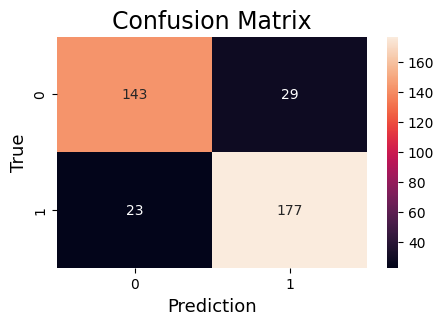

array([[143,  29],
       [ 23, 177]])

In [25]:
confusion_matrix(y_true, y_pred)

In [61]:
y_pred, y_true, y_prob, _ = get_predictions(model, test_loader)
accuracy_score(y_pred, y_true)
# 0.8723404255319149

0.8723404255319149

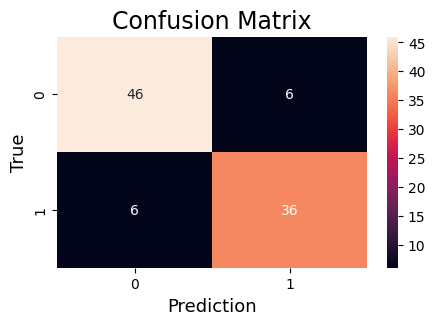

array([[46,  6],
       [ 6, 36]])

In [27]:
confusion_matrix(y_true, y_pred)

# show

0.8801652892561983


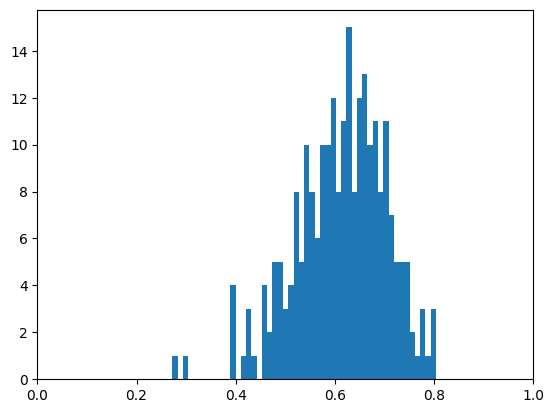

In [62]:
pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
print(accuracy_score(y_pred, y_true))

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.8801652892561983

0.84375


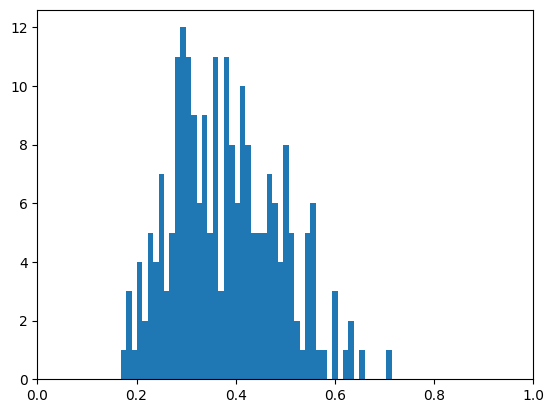

In [63]:
neg_loader = torch.utils.data.DataLoader(neg_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, neg_loader)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.84375

prob > 0.8
count : 2 out of 242
pic idx : [79, 84]


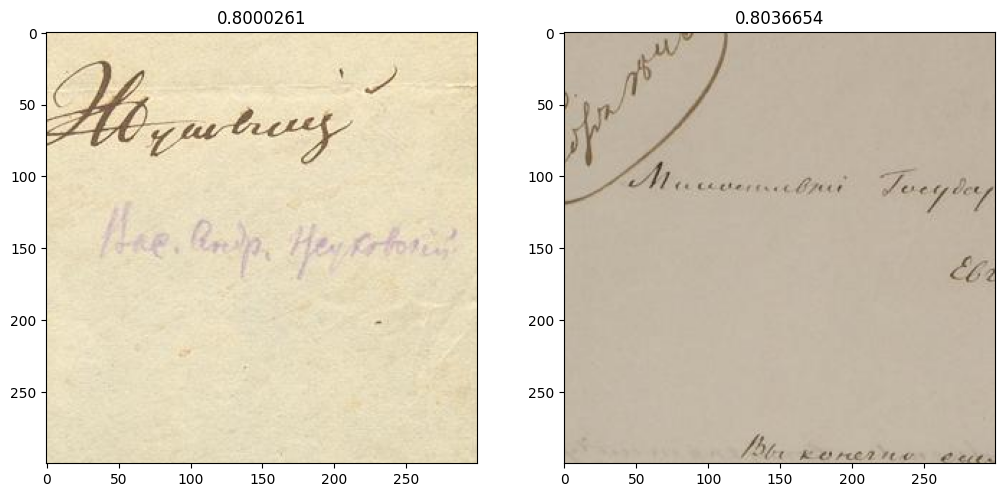

In [30]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.8, greater = True, col = 8)

In [31]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.6, greater = False, col = 8)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.5, greater = True, col = 24)

Output hidden; open in https://colab.research.google.com to view.

In [33]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.5, greater = True, col = 16, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

In [34]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.3, greater = False, col = 24, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.6, greater = True, col = 16, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

In [64]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.